# Jupyter notebooks to check tracing of NRES flat fields

In this notebook we check the tracing of the echelle orders. We will load the trace file intermediate product and download a raw flat field image to overlay the tracing on the flat frame.


In [1]:
# Import stuff
import os
from astropy.io import fits
import numpy as np

# For matplotlib plotting
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
# import request to download flat image from archive
import requests

## Prepare notebook to download data from the archive

You need a `userdat.dat` file in your home directory or somewhere else. This file has the following two lines:
```
username=
password=
```
You have to insert user name and password after `=` sign.



In [2]:
# Get data from user file:
user_file = open('/home/mrabus/userdata.dat', 'r') # File with the username and password to access the archive
#read username and password
username  = (user_file.readline().split('=')[-1]).split()[0]
password  = (user_file.readline().split('=')[-1]).split()[0]
# Request token and create header to access the archive
api_token = requests.post('https://archive-api.lco.global/api-token-auth/',data = {'username': username,'password': password}).json() 
headers={'Authorization': 'Token '+api_token['token']}  

## Intermediate trace data product

The trace file is an intermediate data product which is not in the archive. We also define the NRES site. Copy the intermediate data product into the data root path.

In [3]:
site      = 'cpt' 
rootdir   = os.path.join( 'data/', site) # Data root directory: where we have copied the intermediate trace and 
                                         # the flat field will be dowloaded in this directory
tracefile = 'TRACcpt2020021.49693.fits' # Define the trace file to be checked
trace     = fits.open( os.path.join( rootdir, tracefile) )

## Download raw flat
We download the raw flat image from the archive. 

In [4]:
flatfile  = trace[0].header['FILE_IN'].split('/')[-1] # get corresponding flat filename
if not os.path.exists( os.path.join( rootdir,flatfile+'.fz' ) ):
    # if file not exits download it
    response = requests.get('https://archive-api.lco.global/frames/?start=&end=&OBSTYPE=&basename='+\
                            flatfile.strip('.fits')+'&RLEVEL=&TELID=',headers=headers).json()
    frames = response['results']
    # Download all frames
    for frame in frames:
        with open( os.path.join(rootdir, frame['filename']) , 'wb') as ff:
            ff.write(requests.get(frame['url']).content)

## Open fits hdu and get data of raw flat

In [5]:
fitsfile = os.path.join( rootdir,flatfile+'.fz' )
hdurawspec = fits.open( fitsfile )
image = hdurawspec['SPECTRUM'].data

## Create trace 
Trace file save the coefficient of the Legendre polynomials used to trace the files. Legendre polynomials are orthogonal.

In [6]:
order = 10 #choose order to trace
pixel_sampling = 1 #pixel sampling for the trace 
n_polynomial_coefficients = int(trace[0].header['NPOLY']) # get the degree
# create x value for polynomial evaluation
x = np.arange(0, int(trace[0].header['NX']), pixel_sampling)
normalized_x = (0.5 + x) / int(trace[0].header['NX']) - 0.5
normalized_x *= 2.0
# get coefficient for each fibre from header and create trace for each fibre
coefficients_f0 = trace[0].data[0, 0, order, :n_polynomial_coefficients]
coefficients_f1 = trace[0].data[0, 1, order, :n_polynomial_coefficients]
polynomial_f0 = np.polynomial.legendre.Legendre(coefficients_f0)
polynomial_f1 = np.polynomial.legendre.Legendre(coefficients_f1)
trace_center_positions_f0 = polynomial_f0(normalized_x)
trace_center_positions_f1 = polynomial_f1(normalized_x)

## Plot flat and overplot traces
Visiual expection that the traces follow the raw flat. Colored lines correspond to the trace of the respective fibre.

(1800, 2200)

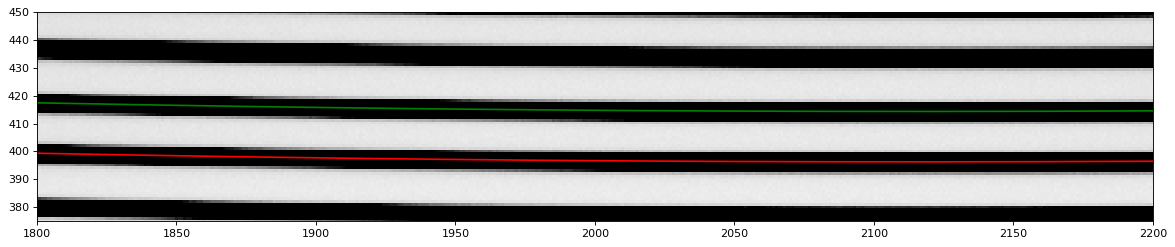

In [7]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
interval = ZScaleInterval()
(vmin,vmax) = interval.get_limits( image )
plt.imshow(image, cmap='Greys', vmin=vmin, vmax=vmax, origin='lower' )
plt.plot(x,trace_center_positions_f0,'g',alpha=1)
plt.plot(x,trace_center_positions_f1,'r',alpha=1)
plt.ylim(375,450)
plt.xlim(1800,2200)